In [1]:
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import pandas as pd
import time
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [2]:
# Data preprocessing from XGBoostModel.ipynb
# Get the parent directory (DS3000-Group-4) and navigate to Data
current_dir = os.getcwd()
data_path = os.path.join(os.path.dirname(current_dir), 'Data', 'mxmh_survey_results.csv')

df = pd.read_csv(data_path) # Load the dataset
df = df.drop(columns=['Exploratory', 'Timestamp', 
                      'Primary streaming service', 'BPM', 'Music effects', 'Permissions']) # Drop unnecessary columns
df = df.dropna() # Drop rows with any missing values
df.head() # Display the first few rows of the cleaned dataset
# Drop gospel, as we do not have enough data points on those who listen to it sometimes or very frequently
df = df.drop(columns=['Frequency [Gospel]'])

In [3]:
# Frame mental health condition columns as classification targets
mh_condition = ['Depression', 'OCD', 'Anxiety', 'Insomnia' ]

def to_3class(score_series):
    """
    Map numeric scores to 3 classes:
    0–3  -> 0 (Low)
    4–6  -> 1 (Moderate)
    7–10 -> 2 (High)
    """
    bins = [-np.inf, 3.0, 6.0, np.inf] # Define class bin edges
    labels = [0, 1, 2] # Corresponding class labels
    return pd.cut(score_series, bins=bins, labels=labels).astype(int) # Convert to int type


# Convert target columns if they exist
target_conditions = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
for t in target_conditions:
    if t in df.columns:
        df[f"{t}_class"] = to_3class(df[t])

# Drop original target columns if they exist
existing_targets = [t for t in target_conditions if t in df.columns]
if existing_targets:
    df = df.drop(columns=existing_targets)    

df.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Latin,Yes,Rarely,Never,Rarely,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,0,0,0,0
1,63.0,1.5,Yes,No,No,Rock,No,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,2,0,0,0
2,18.0,4.0,No,No,No,Video game music,Yes,Never,Never,Very frequently,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Jazz,Yes,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Never,Never,Never,2,2,0,0
4,18.0,4.0,Yes,No,No,R&B,No,Never,Never,Rarely,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,2,0,1,2


In [4]:
# Define frequency mapping
freq_map = {
    "Never": 0,
    "Rarely": 1,
    "Sometimes": 2,
    "Frequently": 3,
    "Very frequently": 4
}

# Copy df to avoid mutating original
df_fe = df.copy()

# Identify genre frequency columns
freq_cols = [col for col in df.columns if col.startswith("Frequency")]


# Convert frequency columns to numeric using the mapping
for col in freq_cols:
    df_fe[col] = df_fe[col].map(freq_map).astype(float)


# Create a normalised genre name lookup so "Fav genre" matches frequency column names
# Example: "Rock" → "Frequency [Rock]"
def genre_to_freq_column(genre):
    return f"Frequency [{genre}]"

BOOST_AMOUNT = 1.0   # You may tune this later

def convert_fav_genre_to_freq_col(genre):
    """Convert 'Rock' → 'Frequency [Rock]'."""
    return f"Frequency [{genre}]"

for idx, row in df_fe.iterrows():
    fav = row["Fav genre"]
    target_col = convert_fav_genre_to_freq_col(fav)

    if target_col in freq_cols:
        df_fe.loc[idx, target_col] = df_fe.loc[idx, target_col] + BOOST_AMOUNT

# Drop original Fav genre column if model should not see it
df_fe = df_fe.drop(columns=["Fav genre"])

# Display the processed dataframe
df_fe.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Yes,1.0,0.0,1.0,0.0,...,0.0,4.0,2.0,4.0,0.0,2.0,0,0,0,0
1,63.0,1.5,Yes,No,No,No,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,1.0,5.0,1.0,2,0,0,0
2,18.0,4.0,No,No,No,Yes,0.0,0.0,4.0,0.0,...,2.0,1.0,0.0,1.0,1.0,5.0,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Yes,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,0.0,0.0,0.0,2,2,0,0
4,18.0,4.0,Yes,No,No,No,0.0,0.0,1.0,0.0,...,0.0,2.0,5.0,4.0,0.0,1.0,2,0,1,2


In [5]:
# Start from a clean copy of the original dataframe
df_fe1 = df_fe.copy()

# Clean col names to avoid key errors
df_fe1.columns = (
    df_fe1.columns.astype(str)
    .str.strip()
    .str.replace('\xa0', '', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
)

print("Cleaned column names:", df_fe1.columns.tolist())

# Define age group bins and labels
age_bins = [0, 17, 25, 35, 45, 55, 65, np.inf]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

if 'Age' not in df_fe1.columns:
    raise KeyError("'Age' column not found in dataframe.")

# Create Age Group categorical feature
df_fe1['Age Group'] = pd.cut(
    df_fe1['Age'], bins=age_bins, labels=age_labels
)

# One-hot encode Age Group (categorical, not ordinal!)
df_fe1 = pd.get_dummies(df_fe1, columns=['Age Group'], prefix='AgeGroup')

# Drop the original Age column if not needed
df_fe1 = df_fe1.drop(columns=['Age'])

# AUTO-DETECT YES/NO COLUMNS
yes_no_cols = []
for col in df_fe1.columns:
    nonnull = df_fe1[col].dropna().unique()
    if len(nonnull) > 0 and set(nonnull).issubset({'Yes', 'No'}):
        yes_no_cols.append(col)
    if len(nonnull) > 0 and set(nonnull).issubset({True, False}):
        yes_no_cols.append(col)

print("Detected Yes/No columns:", yes_no_cols)

# Convert boolean to binary 1/0
for col in yes_no_cols:
    df_fe1[col] = df_fe1[col].map({'Yes': 1, 'No': 0, True: 1, False: 0})

df_fe1.head(10) # Display the first 10 rows of the final feature-engineered dataframe


Cleaned column names: ['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Composer', 'Foreign languages', 'Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Hip hop]', 'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]', 'Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class']
Detected Yes/No columns: ['While working', 'Instrumentalist', 'Composer', 'Foreign languages', 'AgeGroup_<18', 'AgeGroup_18-24', 'AgeGroup_25-34', 'AgeGroup_35-44', 'AgeGroup_45-54', 'AgeGroup_55-64', 'AgeGroup_65+']


,Hours per day,While working,Instrumentalist,Composer,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Hip hop],...,Depression_class,Insomnia_class,OCD_class,AgeGroup_<18,AgeGroup_18-24,AgeGroup_25-34,AgeGroup_35-44,AgeGroup_45-54,AgeGroup_55-64,AgeGroup_65+
0,3.0,1,1,1,1,1.0,0.0,1.0,0.0,2.0,...,0,0,0,0,1,0,0,0,0,0
1,1.5,1,0,0,0,2.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0
2,4.0,0,0,0,1,0.0,0.0,4.0,0.0,1.0,...,2,2,0,0,1,0,0,0,0,0
3,2.5,1,0,1,1,2.0,0.0,0.0,1.0,0.0,...,2,0,0,0,0,0,0,0,1,0
4,4.0,1,0,0,0,0.0,0.0,1.0,0.0,4.0,...,0,1,2,0,1,0,0,0,0,0
5,5.0,1,1,1,1,1.0,2.0,0.0,0.0,2.0,...,2,2,2,0,1,0,0,0,0,0
6,3.0,1,1,0,1,2.0,0.0,1.0,2.0,1.0,...,2,1,0,0,1,0,0,0,0,0
7,1.0,1,0,0,1,0.0,0.0,1.0,0.0,4.0,...,0,1,0,0,1,0,0,0,0,0
8,6.0,1,0,0,0,0.0,4.0,0.0,2.0,0.0,...,0,0,0,0,1,0,0,0,0,0
9,1.0,1,0,0,1,1.0,1.0,1.0,1.0,1.0,...,0,1,0,0,1,0,0,0,0,0


In [6]:
# Testing with just Depression_class
X = df_fe1.drop(['Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class'], axis = 1)
y = df_fe1['Depression_class']

# Split the data into train, validation and test and hold out 20% and 10% of observations as the validation and test set, respectively. Pass random_state=42.
#First split 70% into train and then another 30% into temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
#Split the 30% into 20% for validation and 10% for testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

In [7]:
training_times = {}
mlp_train_losses = []
mlp_val_losses = []

#MLP
mlp = Sequential()
mlp.add(Dense(50, input_shape=(X_train.shape[1],), activation='tanh'))
mlp.add(Dense(100, activation='tanh'))
mlp.add(Dense(11, activation='softmax'))

mlp.compile(
    optimizer=SGD(learning_rate=0.1),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
start_time = time.time()
history_mlp = mlp.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=0
)

end_time = time.time()
training_times['MLP'] = (end_time - start_time) * 1000 # in milliseconds


#Report the training time in milli second for all models.
print("Training Times:")
for model, t_time in training_times.items():
    print(f"  {model}: {t_time:.2f} ms")

# These lists will be used in subsequent steps for plotting learning curves
print("\nMLP Training Losses per epoch:", history_mlp.history['loss'])
print("MLP Validation Losses per epoch:", history_mlp.history['val_loss'])


c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Times:
  MLP: 1890.74 ms

MLP Training Losses per epoch: [1.5044995546340942, 1.124644160270691, 1.1675201654434204, 1.1232588291168213, 1.1006890535354614, 1.1020503044128418, 1.0663107633590698, 1.0659610033035278, 1.10390043258667, 1.0468430519104004]
MLP Validation Losses per epoch: [1.097078800201416, 1.072079062461853, 1.0959280729293823, 1.0383992195129395, 1.1274759769439697, 1.1150792837142944, 1.0860477685928345, 1.036627173423767, 1.1824394464492798, 1.147186517715454]


--- MLP Depression ---
Test accuracy: 0.3835616438356164
Precision: 0.33659491193737767
Recall: 0.3835616438356164
F1 Score: 0.3227739726027397
Confusion Matrix:
 [[15  6 24]
 [ 9  2 39]
 [ 6  6 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.33      0.40        45
           1       0.14      0.04      0.06        50
           2       0.38      0.76      0.51        51

    accuracy                           0.38       146
   macro avg       0.34      0.38      0.32       146
weighted avg       0.34      0.38      0.32       146



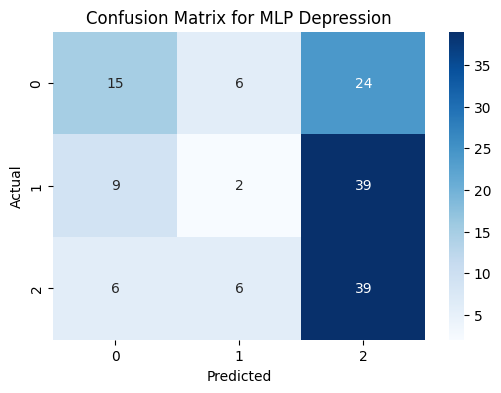

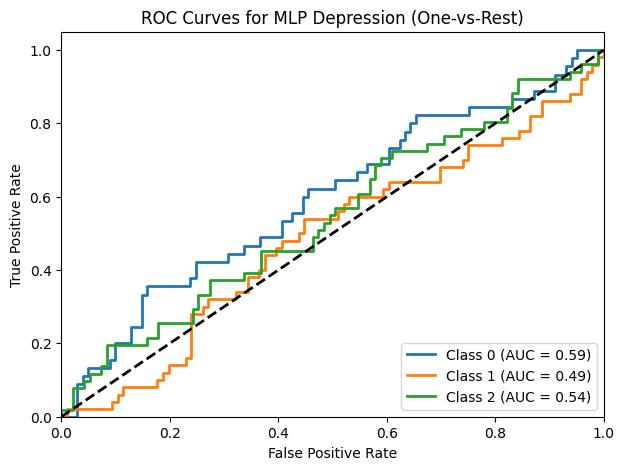


Test Times:
  MLP: 128.32 ms


In [8]:
y_test = np.round(y_test).astype(int)

models = {
    'MLP': mlp
}

test_times = {}

for model_name, model in models.items():
    start_test_time = time.time()

    y_test_pred_for_metrics = None
    y_score_for_roc = None
    
    # Keras models output probabilities directly when predict is called
    # for classification tasks with softmax activation.
    y_pred_proba_keras = model.predict(X_test, verbose=0)
    y_test_pred_for_metrics = np.argmax(y_pred_proba_keras, axis=1) # Convert probabilities to class labels
    y_score_for_roc = y_pred_proba_keras # Probabilities for ROC curve

    end_test_time = time.time()
    test_times[model_name] = (end_test_time - start_test_time) * 1000 # in milliseconds

    print(f"--- {model_name} Depression ---")
    print("Test accuracy:", accuracy_score(y_test, y_test_pred_for_metrics))
    print("Precision:", precision_score(y_test, y_test_pred_for_metrics, average='weighted'))
    print("Recall:", recall_score(y_test, y_test_pred_for_metrics, average='weighted'))
    print("F1 Score:", f1_score(y_test, y_test_pred_for_metrics, average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_for_metrics))
    print("Classification Report:\n", classification_report(y_test, y_test_pred_for_metrics))

    # ---- Confusion Matrix Plot ----
    cm = confusion_matrix(y_test, y_test_pred_for_metrics)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix for {model_name} Depression')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

     # Multiclass classification (One-vs-Rest)
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = y_test_bin.shape[1]

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_for_roc[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(7, 5))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                    lw=2,
                    label=f'Class {classes[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name} Depression (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.show()

# Report the test time (in milli second) for all models.
print("\nTest Times:")
for model, t_time in test_times.items():
    print(f"  {model}: {t_time:.2f} ms")


c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Times:
  MLP: 1784.68 ms

MLP Training Losses per epoch: [1.371663212776184, 1.1005171537399292, 1.1390712261199951, 1.1056649684906006, 1.0424787998199463, 1.0459706783294678, 1.0318114757537842, 1.0591626167297363, 1.0122069120407104, 1.0270546674728394]
MLP Validation Losses per epoch: [1.1825778484344482, 1.14187753200531, 1.1713604927062988, 1.329271912574768, 1.1686309576034546, 1.3489710092544556, 1.1574846506118774, 1.2164708375930786, 1.3371305465698242, 1.1732573509216309]
--- MLP Anxiety_class---
Test accuracy: 0.4246575342465753
Precision: 0.43127286650216967
Recall: 0.4246575342465753
F1 Score: 0.40971228872728366
Confusion Matrix:
 [[13  1 20]
 [ 8  6 23]
 [25  7 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.38      0.33        34
           1       0.43      0.16      0.24        37
           2       0.50      0.57      0.53        75

    accuracy                           0.42       146
   m

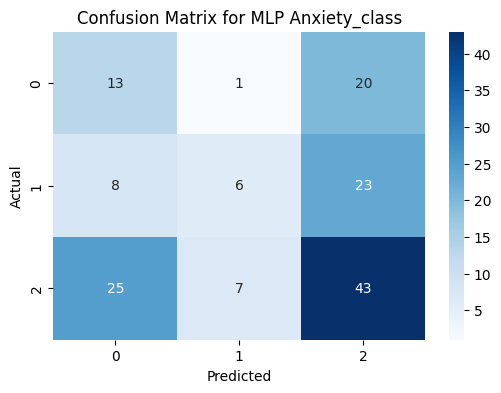

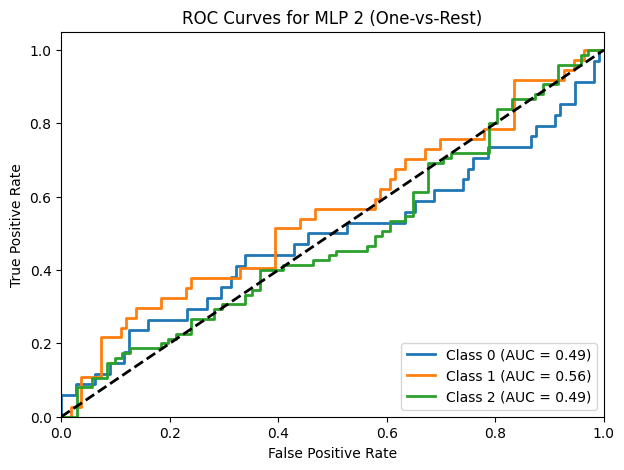


Test Times:
  MLP: 118.52 ms


c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Times:
  MLP: 1520.95 ms

MLP Training Losses per epoch: [1.2991646528244019, 1.0812212228775024, 1.0638508796691895, 1.0129473209381104, 1.0556836128234863, 1.011805534362793, 1.0144295692443848, 1.0296263694763184, 1.0319771766662598, 1.0418403148651123]
MLP Validation Losses per epoch: [1.1100716590881348, 1.1341869831085205, 1.0887433290481567, 1.1413053274154663, 1.199149250984192, 1.1016969680786133, 1.1923092603683472, 1.165055751800537, 1.2113118171691895, 1.091164469718933]
--- MLP Insomnia_class---
Test accuracy: 0.5205479452054794
Precision: 0.3419283071692831
Recall: 0.5205479452054794
F1 Score: 0.392224416197019
Confusion Matrix:
 [[74  0  5]
 [37  0  1]
 [26  1  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.94      0.69        79
           1       0.00      0.00      0.00        38
           2       0.25      0.07      0.11        29

    accuracy                           0.52       146
   mac

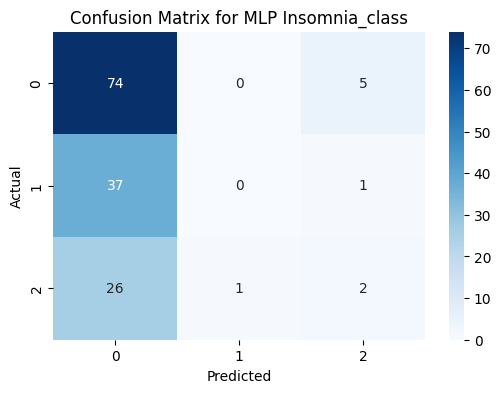

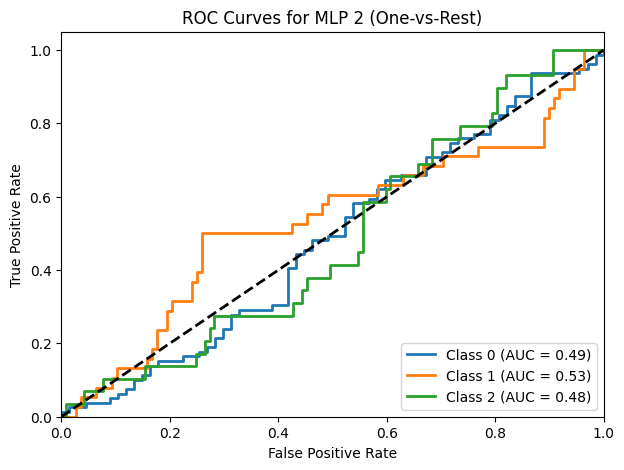


Test Times:
  MLP: 123.75 ms


c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Times:
  MLP: 1957.12 ms

MLP Training Losses per epoch: [1.0890133380889893, 0.9106742739677429, 0.8710141777992249, 0.8369144797325134, 0.8427433967590332, 0.8677019476890564, 0.8094357252120972, 0.8471720814704895, 0.7871694564819336, 0.7806660532951355]
MLP Validation Losses per epoch: [0.8045458197593689, 0.8013502359390259, 0.8427002429962158, 0.8349950909614563, 0.8839489817619324, 0.8297655582427979, 0.8474323749542236, 0.788231611251831, 0.9608845114707947, 0.8116370439529419]
--- MLP OCD_class---
Test accuracy: 0.6232876712328768
Precision: 0.3884875211109027
Recall: 0.6232876712328768
F1 Score: 0.4786428530142766
Confusion Matrix:
 [[91  0  0]
 [26  0  0]
 [29  0  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77        91
           1       0.00      0.00      0.00        26
           2       0.00      0.00      0.00        29

    accuracy                           0.62       146
   macr

c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Isabella\Documents\School\Third_Year\DS_3000_Machine_learning\DS3000-Group-4\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0

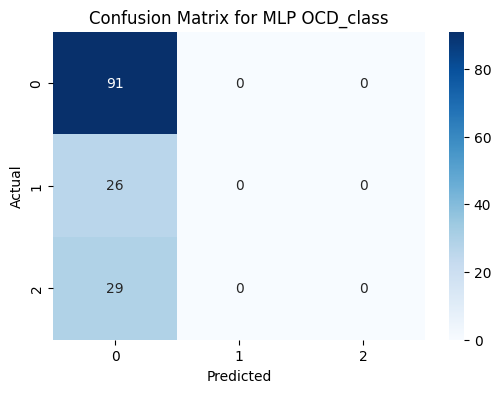

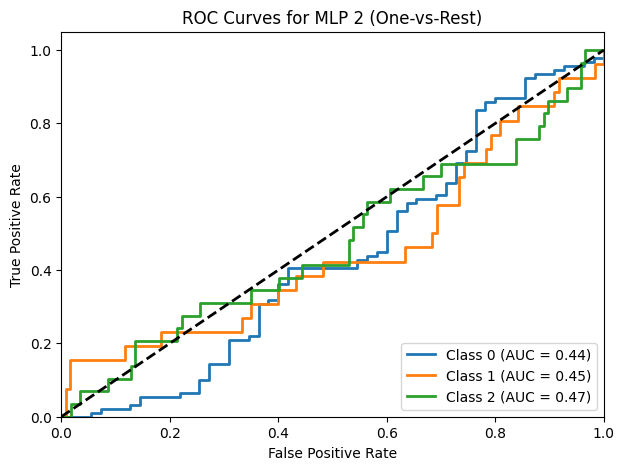


Test Times:
  MLP: 216.69 ms


In [9]:
# Since we know Depression_class worked quite well, loop the same process for the other classes
classes = ['Anxiety_class', 'Insomnia_class', 'OCD_class']
for i in classes:
    X = df_fe1.drop(['Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class'], axis = 1)
    y = df_fe1[i]

    # Split the data into train, validation and test and hold out 20% and 10% of observations as the validation and test set, respectively. Pass random_state=42.
    #First split 70% into train and then another 30% into temp
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    #Split the 30% into 20% for validation and 10% for testing
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

    training_times = {}
    mlp_train_losses = []
    mlp_val_losses = []

    #MLP
    mlp = Sequential()
    mlp.add(Dense(50, input_shape=(X_train.shape[1],), activation='tanh'))
    mlp.add(Dense(100, activation='tanh'))
    mlp.add(Dense(11, activation='softmax'))

    mlp.compile(
        optimizer=SGD(learning_rate=0.1),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    start_time = time.time()
    history_mlp = mlp.fit(
        X_train,
        y_train,
        epochs=10,
        validation_data=(X_val, y_val),
        verbose=0
    )

    end_time = time.time()
    training_times['MLP'] = (end_time - start_time) * 1000 # in milliseconds


    #Report the training time in milli second for all models.
    print("Training Times:")
    for model, t_time in training_times.items():
        print(f"  {model}: {t_time:.2f} ms")

    # These lists will be used in subsequent steps for plotting learning curves
    print("\nMLP Training Losses per epoch:", history_mlp.history['loss'])
    print("MLP Validation Losses per epoch:", history_mlp.history['val_loss'])

    y_test = np.round(y_test).astype(int)

    models = {
        'MLP': mlp
    }

    test_times = {}

    for model_name, model in models.items():
        start_test_time = time.time()

        y_test_pred_for_metrics = None
        y_score_for_roc = None
        
        # Keras models output probabilities directly when predict is called
        # for classification tasks with softmax activation.
        y_pred_proba_keras = model.predict(X_test, verbose=0)
        y_test_pred_for_metrics = np.argmax(y_pred_proba_keras, axis=1) # Convert probabilities to class labels
        y_score_for_roc = y_pred_proba_keras # Probabilities for ROC curve

        end_test_time = time.time()
        test_times[model_name] = (end_test_time - start_test_time) * 1000 # in milliseconds

        print(f"--- {model_name} {i}---")
        print("Test accuracy:", accuracy_score(y_test, y_test_pred_for_metrics))
        print("Precision:", precision_score(y_test, y_test_pred_for_metrics, average='weighted'))
        print("Recall:", recall_score(y_test, y_test_pred_for_metrics, average='weighted'))
        print("F1 Score:", f1_score(y_test, y_test_pred_for_metrics, average='weighted'))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_for_metrics))
        print("Classification Report:\n", classification_report(y_test, y_test_pred_for_metrics))

        # ---- Confusion Matrix Plot ----
        cm = confusion_matrix(y_test, y_test_pred_for_metrics)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title(f'Confusion Matrix for {model_name} {i}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Multiclass classification (One-vs-Rest)
        classes = np.unique(y_test)
        y_test_bin = label_binarize(y_test, classes=classes)
        n_classes = y_test_bin.shape[1]

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_for_roc[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(7, 5))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i],
                        lw=2,
                        label=f'Class {classes[i]} (AUC = {roc_auc[i]:0.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves for {model_name} {i} (One-vs-Rest)')
        plt.legend(loc="lower right")
        plt.show()

    # Report the test time (in milli second) for all models.
    print("\nTest Times:")
    for model, t_time in test_times.items():
        print(f"  {model}: {t_time:.2f} ms")
